In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset/mydataset.csv")

# Convert timestamp to datetime, infer format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)

# Check for rows that couldn't be converted
invalid_dates = df[df['timestamp'].isna()]
print(f"Rows with invalid timestamps: {len(invalid_dates)}")

# Preview the data
df.head()


Rows with invalid timestamps: 1209


C:\Users\NIDHI HARISH K\AppData\Local\Temp\ipykernel_11404\134776922.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)


,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,NaT,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,NaT,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [3]:
from datetime import datetime

# Define a function to try multiple formats
def parse_timestamp(ts):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y %H:%M:%S"):
        try:
            return datetime.strptime(ts, fmt)
        except:
            continue
    return pd.NaT

# Apply the function
df['timestamp'] = df['timestamp'].astype(str).apply(parse_timestamp)

# Check again for any remaining invalid timestamps
invalid_dates = df[df['timestamp'].isna()]
print(f"Rows still invalid: {len(invalid_dates)}")

# Preview fixed data
df.head()


Rows still invalid: 1209


,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,NaT,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,NaT,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [4]:
df_clean = df.copy()  # Keep all rows


In [5]:
import re

def clean_log_message(text):
    # Lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Optional: Remove special characters except essential punctuation
    text = re.sub(r'[^a-z0-9\s\.\-_:\/]', '', text)
    
    return text.strip()

# Apply preprocessing
df_clean['log_message_clean'] = df_clean['log_message'].astype(str).apply(clean_log_message)

# Preview
df_clean[['log_message', 'log_message_clean']].head(5)


,log_message,log_message_clean
0,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,nova.osapi_compute.wsgi.server req-b9718cd8-f6...
1,Email service experiencing issues with sending,email service experiencing issues with sending
2,Unauthorized access to data was attempted,unauthorized access to data was attempted
3,nova.osapi_compute.wsgi.server [req-4895c258-b...,nova.osapi_compute.wsgi.server req-4895c258-b2...
4,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,nova.osapi_compute.wsgi.server req-ee8bc8ba-92...


In [6]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Load pretrained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # small and fast

# Generate embeddings
log_messages = df_clean['log_message_clean'].tolist()
embeddings = model.encode(log_messages, show_progress_bar=True)

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"Embeddings shape: {embeddings.shape}")


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Embeddings shape: (2410, 384)


In [8]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize embeddings for better clustering
scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(emb_scaled)

# Add cluster labels to dataframe
df_clean['cluster'] = clusters

# Inspect cluster distribution
print(df_clean['cluster'].value_counts())


cluster
-1    2259
 0      60
 3      51
 2       9
 5       9
 1       6
 4       6
 6       5
 7       5
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Features and labels
X = embeddings  # BERT embeddings
y = df_clean['target_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     precision    recall  f1-score   support

     Critical Error       0.94      1.00      0.97        29
Deprecation Warning       0.00      0.00      0.00         1
              Error       1.00      0.94      0.97        33
        HTTP Status       1.00      1.00      1.00       205
     Resource Usage       1.00      1.00      1.00        38
     Security Alert       0.99      1.00      0.99        76
System Notification       1.00      1.00      1.00        67
        User Action       1.00      1.00      1.00        33

           accuracy                           0.99       482
          macro avg       0.87      0.87      0.87       482
       weighted avg       0.99      0.99      0.99       482



d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [10]:
import re

# Example regex rules for structured logs
regex_rules = {
    'System Notification': r'(uploaded successfully|system notification|user logged in)',
    'User Action': r'(deleted|created|updated|performed action|login|logout)',
    'Deprecation Warning': r'(deprecated|will be removed|obsolete)'
}

def apply_regex_rules(log_msg, current_pred):
    """
    If a regex pattern matches, override the current prediction.
    Otherwise, keep the model prediction.
    """
    for label, pattern in regex_rules.items():
        if re.search(pattern, log_msg, re.IGNORECASE):
            return label
    return current_pred

# Apply regex on test set
log_messages_test = df_clean.iloc[y_test.index]['log_message_clean'].tolist()
y_pred_hybrid = [apply_regex_rules(msg, pred) for msg, pred in zip(log_messages_test, y_pred)]

# Evaluate hybrid model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_hybrid, zero_division=0))


                     precision    recall  f1-score   support

     Critical Error       0.94      1.00      0.97        29
Deprecation Warning       0.00      0.00      0.00         1
              Error       1.00      0.94      0.97        33
        HTTP Status       1.00      1.00      1.00       205
     Resource Usage       1.00      1.00      1.00        38
     Security Alert       0.98      0.66      0.79        76
System Notification       1.00      0.81      0.89        67
        User Action       0.46      1.00      0.63        33

           accuracy                           0.91       482
          macro avg       0.80      0.80      0.78       482
       weighted avg       0.95      0.91      0.92       482



C:\Users\NIDHI HARISH K\AppData\Local\Temp\ipykernel_11404\2495427923.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_clean, palette='tab10')


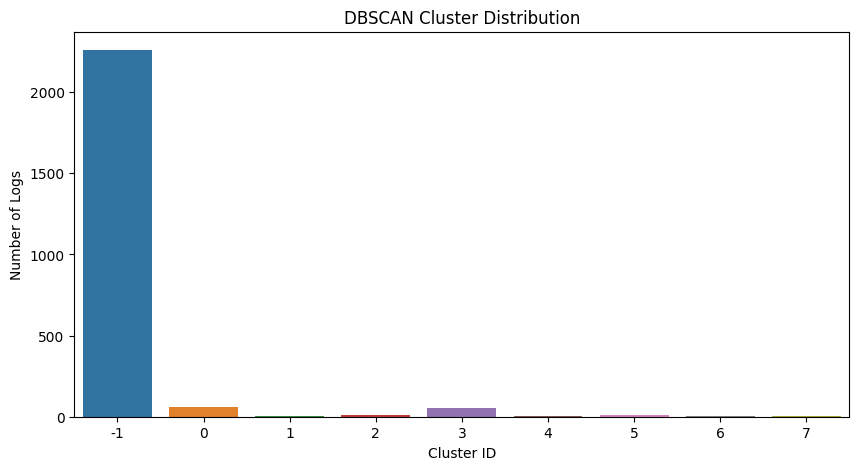

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster distribution
plt.figure(figsize=(10,5))
sns.countplot(x='cluster', data=df_clean, palette='tab10')
plt.title('DBSCAN Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Logs')
plt.show()


In [2]:
# Mark which logs were classified by regex
def source_of_prediction(log_msg, ml_pred):
    for label, pattern in regex_rules.items():
        if re.search(pattern, log_msg, re.IGNORECASE):
            return 'Regex'
    return 'ML'

df_clean['prediction_source'] = [source_of_prediction(msg, pred) for msg, pred in zip(df_clean['log_message_clean'], clf.predict(embeddings))]

# Count of logs by prediction source
plt.figure(figsize=(6,4))
sns.countplot(x='prediction_source', data=df_clean, palette='pastel')
plt.title('Prediction Source: ML vs Regex')
plt.show()


NameError: name 'df_clean' is not defined

In [4]:
import pandas as pd
import re

# Load dataset
df_clean = pd.read_csv("dataset/mydataset.csv")

# If you want to ignore timestamp issues:
df_clean = df_clean.copy()

# Clean log messages
def clean_log_message(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9\s\.\-_:\/]', '', text)
    return text.strip()

df_clean['log_message_clean'] = df_clean['log_message'].astype(str).apply(clean_log_message)


In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_clean['log_message_clean'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

In [7]:
# Print first 10 rows with log, predicted label, and prediction source
print(df_clean[['log_message', 'predicted_label', 'prediction_source']].head(10))

# Or print all rows (careful if dataset is large!)
for idx, row in df_clean.iterrows():
    print(f"Log: {row['log_message']}")
    print(f"Predicted Label: {row['predicted_label']}")
    print(f"Prediction Source: {row['prediction_source']}")
    print("-" * 50)


KeyError: "['predicted_label', 'prediction_source'] not in index"

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster distribution
plt.figure(figsize=(10,5))
sns.countplot(x='cluster', data=df_clean, palette='tab10')
plt.title('DBSCAN Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Logs')
plt.show()


ValueError: Could not interpret value `cluster` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [9]:
import re

# Example regex rules for structured logs
regex_rules = {
    'System Notification': r'(uploaded successfully|system notification|user logged in)',
    'User Action': r'(deleted|created|updated|performed action|login|logout)',
    'Deprecation Warning': r'(deprecated|will be removed|obsolete)'
}

def apply_regex_rules(log_msg, current_pred):
    """
    If a regex pattern matches, override the current prediction.
    Otherwise, keep the model prediction.
    """
    for label, pattern in regex_rules.items():
        if re.search(pattern, log_msg, re.IGNORECASE):
            return label
    return current_pred

# Apply regex on test set
log_messages_test = df_clean.iloc[y_test.index]['log_message_clean'].tolist()
y_pred_hybrid = [apply_regex_rules(msg, pred) for msg, pred in zip(log_messages_test, y_pred)]

# Evaluate hybrid model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_hybrid, zero_division=0))


NameError: name 'y_test' is not defined

In [10]:
df_clean = df.dropna(subset=['timestamp']).reset_index(drop=True)
print(f"Rows remaining: {len(df_clean)}")


NameError: name 'df' is not defined

In [12]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset/mydataset.csv")

# Convert timestamp to datetime, infer format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)

# Check for rows that couldn't be converted
invalid_dates = df[df['timestamp'].isna()]
print(f"Rows with invalid timestamps: {len(invalid_dates)}")

# Preview the data
df.head()


Rows with invalid timestamps: 1209


C:\Users\NIDHI HARISH K\AppData\Local\Temp\ipykernel_10908\134776922.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)


,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,NaT,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,NaT,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [13]:
from datetime import datetime

# Define a function to try multiple formats
def parse_timestamp(ts):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y %H:%M:%S"):
        try:
            return datetime.strptime(ts, fmt)
        except:
            continue
    return pd.NaT

# Apply the function
df['timestamp'] = df['timestamp'].astype(str).apply(parse_timestamp)

# Check again for any remaining invalid timestamps
invalid_dates = df[df['timestamp'].isna()]
print(f"Rows still invalid: {len(invalid_dates)}")

# Preview fixed data
df.head()


Rows still invalid: 1209


,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,NaT,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,NaT,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [14]:
df_clean = df.copy()  # Keep all rows


In [15]:
import re

def clean_log_message(text):
    # Lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Optional: Remove special characters except essential punctuation
    text = re.sub(r'[^a-z0-9\s\.\-_:\/]', '', text)
    
    return text.strip()

# Apply preprocessing
df_clean['log_message_clean'] = df_clean['log_message'].astype(str).apply(clean_log_message)

# Preview
df_clean[['log_message', 'log_message_clean']].head(5)


,log_message,log_message_clean
0,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,nova.osapi_compute.wsgi.server req-b9718cd8-f6...
1,Email service experiencing issues with sending,email service experiencing issues with sending
2,Unauthorized access to data was attempted,unauthorized access to data was attempted
3,nova.osapi_compute.wsgi.server [req-4895c258-b...,nova.osapi_compute.wsgi.server req-4895c258-b2...
4,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,nova.osapi_compute.wsgi.server req-ee8bc8ba-92...


In [16]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Load pretrained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # small and fast

# Generate embeddings
log_messages = df_clean['log_message_clean'].tolist()
embeddings = model.encode(log_messages, show_progress_bar=True)

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"Embeddings shape: {embeddings.shape}")


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Embeddings shape: (2410, 384)


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize embeddings for better clustering
scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(emb_scaled)

# Add cluster labels to dataframe
df_clean['cluster'] = clusters

# Inspect cluster distribution
print(df_clean['cluster'].value_counts())


cluster
-1    2259
 0      60
 3      51
 2       9
 5       9
 1       6
 4       6
 6       5
 7       5
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Features and labels
X = embeddings  # BERT embeddings
y = df_clean['target_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


                     precision    recall  f1-score   support

     Critical Error       0.94      1.00      0.97        29
Deprecation Warning       0.00      0.00      0.00         1
              Error       1.00      0.94      0.97        33
        HTTP Status       1.00      1.00      1.00       205
     Resource Usage       1.00      1.00      1.00        38
     Security Alert       0.99      1.00      0.99        76
System Notification       1.00      1.00      1.00        67
        User Action       1.00      1.00      1.00        33

           accuracy                           0.99       482
          macro avg       0.87      0.87      0.87       482
       weighted avg       0.99      0.99      0.99       482



d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\my projects\log-classification-bert-llm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [19]:
print(classification_report(y_test, y_pred, zero_division=0))


                     precision    recall  f1-score   support

     Critical Error       0.94      1.00      0.97        29
Deprecation Warning       0.00      0.00      0.00         1
              Error       1.00      0.94      0.97        33
        HTTP Status       1.00      1.00      1.00       205
     Resource Usage       1.00      1.00      1.00        38
     Security Alert       0.99      1.00      0.99        76
System Notification       1.00      1.00      1.00        67
        User Action       1.00      1.00      1.00        33

           accuracy                           0.99       482
          macro avg       0.87      0.87      0.87       482
       weighted avg       0.99      0.99      0.99       482



In [20]:
import re

# Example regex rules for structured logs
regex_rules = {
    'System Notification': r'(uploaded successfully|system notification|user logged in)',
    'User Action': r'(deleted|created|updated|performed action|login|logout)',
    'Deprecation Warning': r'(deprecated|will be removed|obsolete)'
}

def apply_regex_rules(log_msg, current_pred):
    """
    If a regex pattern matches, override the current prediction.
    Otherwise, keep the model prediction.
    """
    for label, pattern in regex_rules.items():
        if re.search(pattern, log_msg, re.IGNORECASE):
            return label
    return current_pred

# Apply regex on test set
log_messages_test = df_clean.iloc[y_test.index]['log_message_clean'].tolist()
y_pred_hybrid = [apply_regex_rules(msg, pred) for msg, pred in zip(log_messages_test, y_pred)]

# Evaluate hybrid model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_hybrid, zero_division=0))


                     precision    recall  f1-score   support

     Critical Error       0.94      1.00      0.97        29
Deprecation Warning       0.00      0.00      0.00         1
              Error       1.00      0.94      0.97        33
        HTTP Status       1.00      1.00      1.00       205
     Resource Usage       1.00      1.00      1.00        38
     Security Alert       0.98      0.66      0.79        76
System Notification       1.00      0.81      0.89        67
        User Action       0.46      1.00      0.63        33

           accuracy                           0.91       482
          macro avg       0.80      0.80      0.78       482
       weighted avg       0.95      0.91      0.92       482



C:\Users\NIDHI HARISH K\AppData\Local\Temp\ipykernel_10908\2495427923.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_clean, palette='tab10')


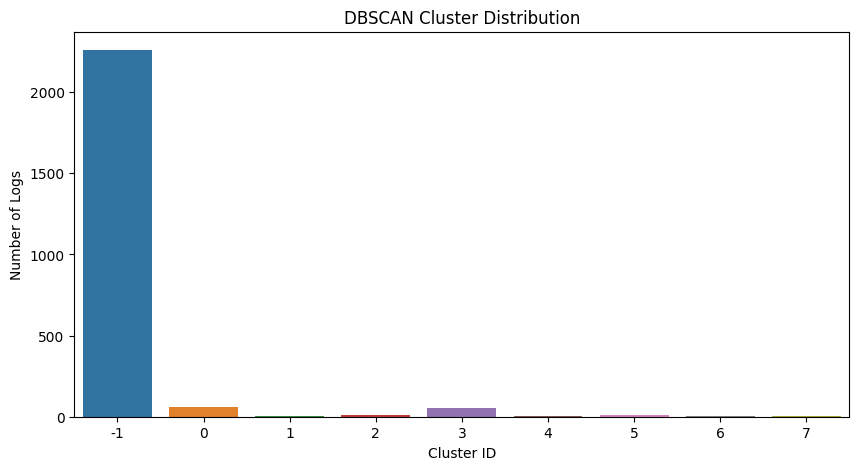

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster distribution
plt.figure(figsize=(10,5))
sns.countplot(x='cluster', data=df_clean, palette='tab10')
plt.title('DBSCAN Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Logs')
plt.show()


C:\Users\NIDHI HARISH K\AppData\Local\Temp\ipykernel_10908\2557184598.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction_source', data=df_clean, palette='pastel')


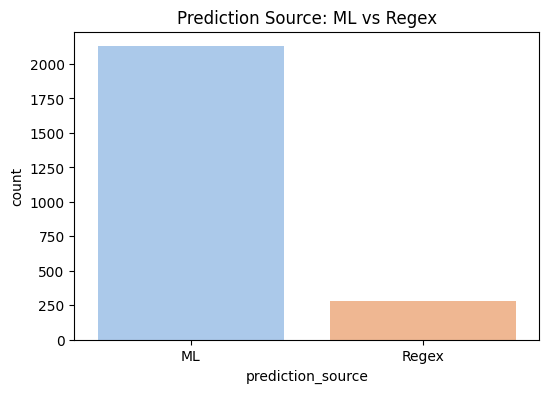

In [22]:
# Mark which logs were classified by regex
def source_of_prediction(log_msg, ml_pred):
    for label, pattern in regex_rules.items():
        if re.search(pattern, log_msg, re.IGNORECASE):
            return 'Regex'
    return 'ML'

df_clean['prediction_source'] = [source_of_prediction(msg, pred) for msg, pred in zip(df_clean['log_message_clean'], clf.predict(embeddings))]

# Count of logs by prediction source
plt.figure(figsize=(6,4))
sns.countplot(x='prediction_source', data=df_clean, palette='pastel')
plt.title('Prediction Source: ML vs Regex')
plt.show()


In [23]:
import pickle

# Save the trained logistic regression model
with open("bert_model.pkl", "wb") as f:
    pickle.dump(clf, f)
